In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
from mpl_toolkits import mplot3d
import numpy as np
import math

### A linear Poisson equation
$\nabla^2 u = sin(\pi x) sin(\pi y)$ \
$0 \leq x \leq 1$ \
$0 \leq y \leq 1$

### Problem specific functions / variables

In [2]:
# partial differential equation
def f(x):
    return torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

def L(model, x):
    y = model(x.float())
    y_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    y_xx = torch.autograd.grad(y_x, x, grad_outputs=torch.ones_like(y_x),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    return torch.sum(y_xx, -1)

# boundary conditions
def g(x):
    return torch.zeros(x.size()[0])

def B(model, x):
    return model(x.float())[:,0]

# Quadrature

N = 20
xs = torch.linspace(0, 1, steps=N, requires_grad=True)
ys = torch.linspace(0, 1, steps=N, requires_grad=True)
x,y = torch.meshgrid(xs, ys)
w = torch.cat((torch.reshape(x, (1,-1)), torch.reshape(y,(1,-1))), 0).T

dw = []
for xy in w:
    if xy[0] == 0 or xy[1] == 0 or xy[0] == 1 or xy[1] == 1:
        dw.append(xy)
dw = torch.stack(dw)

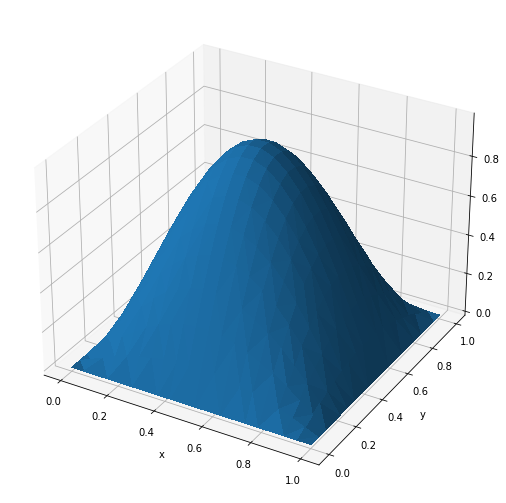

In [3]:
# Creating dataset
z = f(w)
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

xs_plt = w[:,0].detach().numpy()
ys_plt = w[:,1].detach().numpy()
zs_plt = z.detach().numpy()

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, zs_plt, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/analytical_grad2.png')

plt.show()

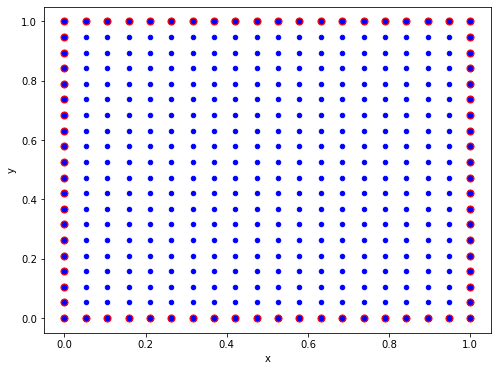

In [4]:
dxs_plt = dw[:,0].detach().numpy()
dys_plt = dw[:,1].detach().numpy()

fig = plt.figure(figsize =(8, 6))
ax = plt.axes()

ax.scatter(dxs_plt,dys_plt, c = 'r', s = 50)
ax.scatter(xs_plt,ys_plt, c = 'b', s = 20)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/quadrature.png')

plt.show()

In [5]:
# MC point selection
def quadMC(N):
    w = torch.rand((N ** 2, 2), requires_grad=True)
    dw = torch.rand((4 * N, 1))
    fw = torch.cat((torch.ones((2 * N, 1)), torch.zeros(2 * N, 1)))
    dw = torch.cat((dw, fw), -1)
    dw[N:(3 * N), :] = torch.flip(dw[N:(3 * N), :], (1,))
    dw.requires_grad = True
    return w, dw

w_mc, dw_mc = quadMC(20)

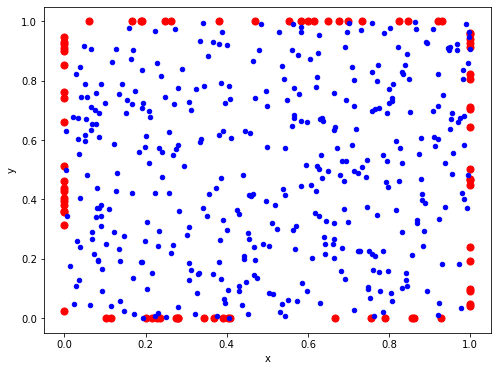

In [6]:
xs_plt = w_mc[:,0].detach().numpy()
ys_plt = w_mc[:,1].detach().numpy()

dxs_plt = dw_mc[:,0].detach().numpy()
dys_plt = dw_mc[:,1].detach().numpy()

fig = plt.figure(figsize =(8, 6))
ax = plt.axes()

ax.scatter(dxs_plt,dys_plt, c = 'r', s = 50)
ax.scatter(xs_plt,ys_plt, c = 'b', s = 20)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/quadrature_mc.png')

plt.show()

### Loss function

In [7]:
def h(model, w_, dw_):
    df = L(model, w_) - f(w_)
    dg = B(model, dw_) - g(dw_)
    df_loss = torch.sum(torch.square(df)) / (N ** 2)
    dg_loss = torch.sum(torch.square(dg)) / N
    loss = df_loss + dg_loss
    return loss, df_loss, dg_loss

### Neural Network

In [8]:
class MyFunction(nn.Module):
    def __init__(self,input_size=2,output_size=1):
        super(MyFunction, self).__init__()
        self.linear1 = nn.Linear(input_size,5)
        self.linear2 = nn.Linear(5,5)
        self.linear3 = nn.Linear(5,output_size)

    def forward(self,x):
        z = torch.sigmoid(self.linear1(x))
        z = torch.sigmoid(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z

pdeApprox = MyFunction()

### Training loop

In [9]:
optimizer = torch.optim.Adam(pdeApprox.parameters(), lr=0.001)
losses = []
#train the neural network for 5 epochs
for epoch in range(10000):      
    #reset gradients
    optimizer.zero_grad()
        
    #calculate the loss
    w_mc, dw_mc = quadMC(20)
    loss = h(pdeApprox, w_mc, dw_mc)
    losses.append(np.array(torch.tensor(loss, requires_grad=False)))
    if epoch % 500 == 0:
        print("Epoch: {e} - Loss: {l:.6f} - Loss (df): {dfl:.6f} - Loss (dg): {dgl:.6f}".format(e=epoch, l=loss[0].item(), dfl=loss[1].item(), dgl=loss[2].item()))
        
    #backpropagation
    loss[0].backward(retain_graph=True)
    
    #update the parameters
    optimizer.step()

Epoch: 0 - Loss: 0.981217 - Loss (df): 0.251794 - Loss (dg): 0.729423
Epoch: 500 - Loss: 0.316020 - Loss (df): 0.249619 - Loss (dg): 0.066401
Epoch: 1000 - Loss: 0.232556 - Loss (df): 0.213499 - Loss (dg): 0.019057
Epoch: 1500 - Loss: 0.184216 - Loss (df): 0.167226 - Loss (dg): 0.016991
Epoch: 2000 - Loss: 0.107812 - Loss (df): 0.084704 - Loss (dg): 0.023108
Epoch: 2500 - Loss: 0.097238 - Loss (df): 0.076192 - Loss (dg): 0.021046
Epoch: 3000 - Loss: 0.086656 - Loss (df): 0.070239 - Loss (dg): 0.016417
Epoch: 3500 - Loss: 0.074235 - Loss (df): 0.053106 - Loss (dg): 0.021130
Epoch: 4000 - Loss: 0.058935 - Loss (df): 0.041389 - Loss (dg): 0.017546
Epoch: 4500 - Loss: 0.047150 - Loss (df): 0.030745 - Loss (dg): 0.016405
Epoch: 5000 - Loss: 0.047155 - Loss (df): 0.025279 - Loss (dg): 0.021876
Epoch: 5500 - Loss: 0.039851 - Loss (df): 0.020205 - Loss (dg): 0.019645
Epoch: 6000 - Loss: 0.038968 - Loss (df): 0.019169 - Loss (dg): 0.019798
Epoch: 6500 - Loss: 0.034758 - Loss (df): 0.016120 - Lo

### Neural Network Approximation

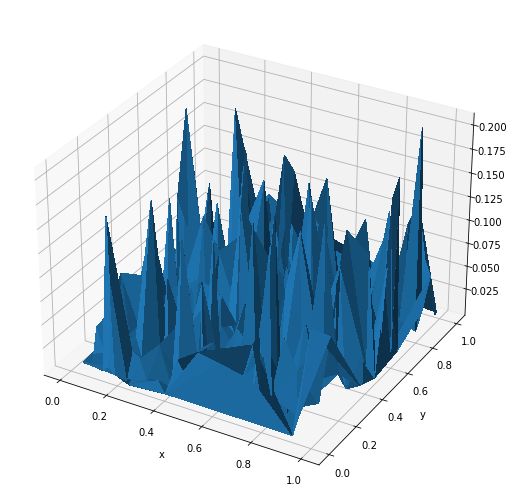

In [10]:
# Creating dataset
pred = pdeApprox(w)[:,0].detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, pred, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/pred.png')

plt.show()

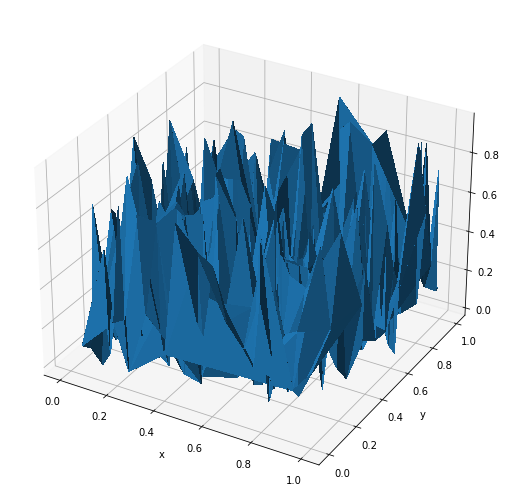

In [11]:
# Creating dataset
grad2 = L(pdeApprox, w).detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, grad2, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/pred_grad2.png')

plt.show()

### Training Curve

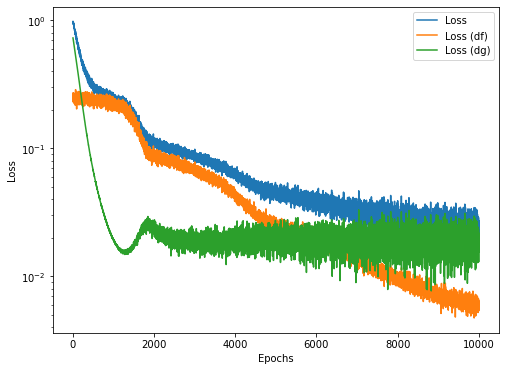

In [12]:
losses = np.array(losses)

fig = plt.figure(figsize =(8, 6))
ax = plt.axes()

ax.plot(losses[:,0], label = "Loss")
ax.plot(losses[:,1], label = "Loss (df)")
ax.plot(losses[:,2], label = "Loss (dg)")

ax.set(xlabel="Epochs", ylabel="Loss")
ax.set_yscale('log')
ax.legend()

plt.savefig('../Figures/training_curve.png')
plt.show()

### Analytical Solution

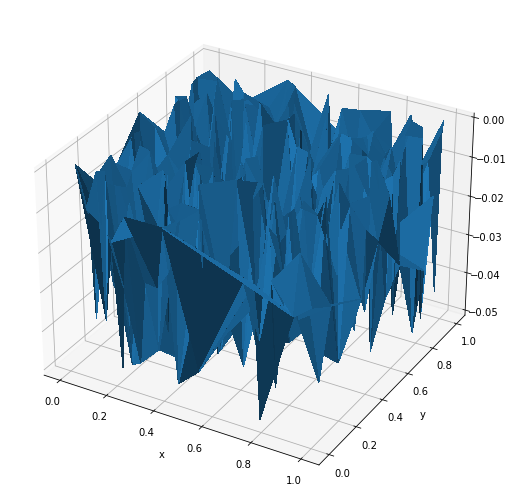

In [13]:
def analytical(x):
    return - 1 / (2 * torch.tensor(math.pi) ** 2) * torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

# Creating dataset
solution = analytical(w).detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, solution, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/analytical_solution.png')

plt.show()